### Importing Required Libraries

In [1]:
# Imports
import numpy as np
from PIL import Image
import time

import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

### Image Utility Functions

In [2]:
def load_image(filename, max_size=None):
    image = Image.open(filename)

    if max_size is not None:
        # Resize the image.
        image = image.resize((max_size,max_size))
    return image

def save_image(image, filename):
    filename = str(filename)
    path = 'output_images/'+filename
    image.save(path+'.jpeg')
    
    
# Data normalization and reshaping from RGB to BGR
def image_preprocess(image):
    image_array = np.asarray(image, dtype="float32")
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array[:, :, :, ::-1]
    return image_array

def plot_image(image):
    plt.imshow(image)
    plt.show()
    
def array_to_image(im_array):
    im_array = im_array.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    im_array = im_array[:, :, ::-1]
    im_array = np.clip(im_array, 0.0, 255.0)
    # Convert pixels to bytes.
    im_array = im_array.astype(np.uint8)
    # Convert to a PIL-image and display it.
    im = Image.fromarray(im_array)
    return im
    
def plot_image_array(image_array):
    # Create figure with sub-plots.
    n=len(image_array)
    fig, axes = plt.subplots(1, n, figsize=(30, 10))
    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(n):
        ax = axes.flat[i]
        ax.imshow(image_array[i])
    plt.show()

### Hyperparams

In [3]:
ITERATIONS = 20
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
CONTENT_WEIGHT = 0.05
STYLE_WEIGHT = 5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

### Loading and Preporcessing the Images

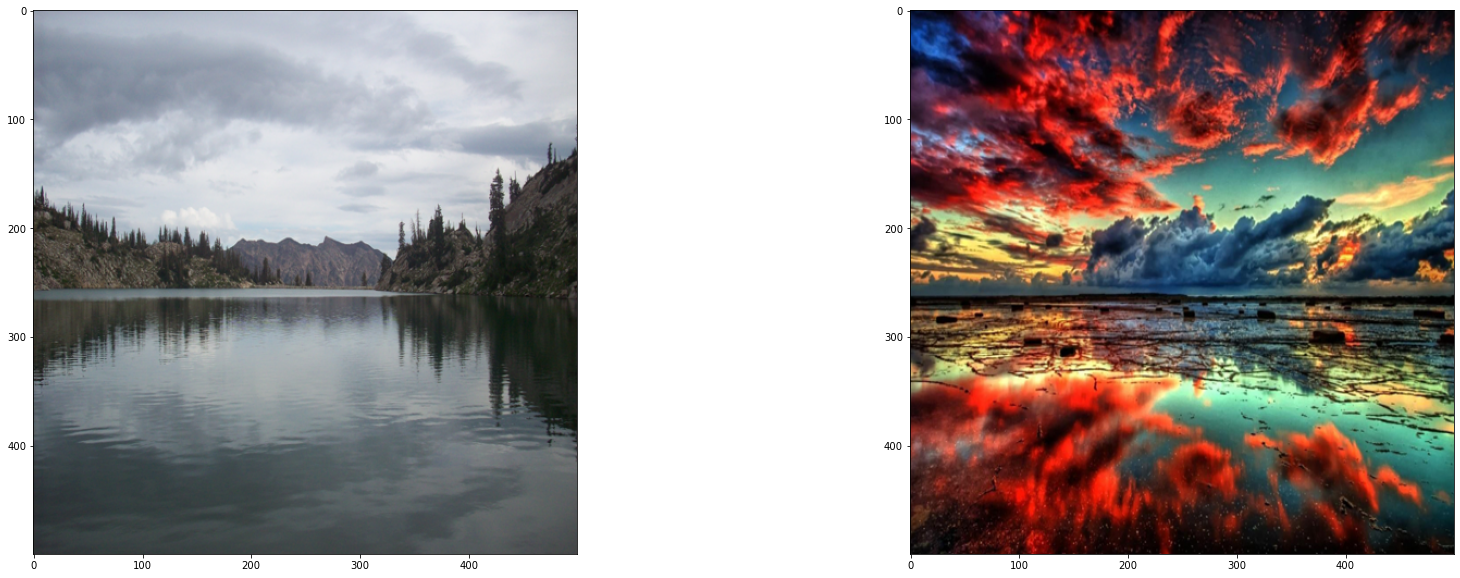

In [4]:
input_image = load_image('input_images/in2.png',IMAGE_SIZE)
style_image = load_image('style_images/style1.png',IMAGE_SIZE)

arr = [input_image,style_image]

input_image_array = image_preprocess(input_image)
style_image_array  = image_preprocess(style_image)

plot_image_array(arr)

### Initializing the Model

In [5]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

### Defining Loss Functions for Style Transfer

In [6]:
def compute_content_loss(content, combination):
    return backend.sum(backend.square(combination - content))


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))


def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

### Methods for Loss and Gradients

In [7]:
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

### Layers to extract Features and apply Loss Function

In [8]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

# Content Layer for Content Loss
content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss = loss + (CONTENT_WEIGHT * compute_content_loss(content_image_features,combination_features))

# Style Layer for Style Loss
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + ((STYLE_WEIGHT / len(style_layers)) * style_loss)
    
# Total Variation Loss
loss = loss + (TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image))

outputs = [loss]
outputs += backend.gradients(loss, combination_image)

# Initializing the output image
output_image = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

### Iterating via BFGS Algorithm

In [9]:
N = [1,2,5,10,15,20]
output_array = []

for i in range(ITERATIONS+1):
    
    if i in N:
        name = str(i) + "_Iteration_output"
        img = array_to_image(output_image)
        output_array.append(img)
        save_image(img,name)
    
    if i == (ITERATIONS+1):
        break
        
    begin = time.time()
    output_image, loss, info = fmin_l_bfgs_b(evaluator.loss, output_image.flatten(), fprime=evaluator.gradients, maxfun=20)
    end = time.time()
    time_taken = end - begin
    print("Iteration %d completed with loss %d in time %fs" % (i+1, loss,time_taken))

Iteration 1 completed with loss 292055777280 in time 43.520863s
Iteration 2 completed with loss 131460096000 in time 33.338406s
Iteration 3 completed with loss 78836809728 in time 34.168267s
Iteration 4 completed with loss 62326763520 in time 34.075882s
Iteration 5 completed with loss 57274781696 in time 34.122091s
Iteration 6 completed with loss 54947229696 in time 34.546730s
Iteration 7 completed with loss 53753176064 in time 34.342379s
Iteration 8 completed with loss 53084434432 in time 34.064817s
Iteration 9 completed with loss 52676898816 in time 33.843870s
Iteration 10 completed with loss 52413386752 in time 32.507538s
Iteration 11 completed with loss 52234010624 in time 32.774782s
Iteration 12 completed with loss 52099932160 in time 32.911408s
Iteration 13 completed with loss 52006162432 in time 32.929231s
Iteration 14 completed with loss 51936620544 in time 33.010788s
Iteration 15 completed with loss 51882971136 in time 32.967357s
Iteration 16 completed with loss 51840241664 in

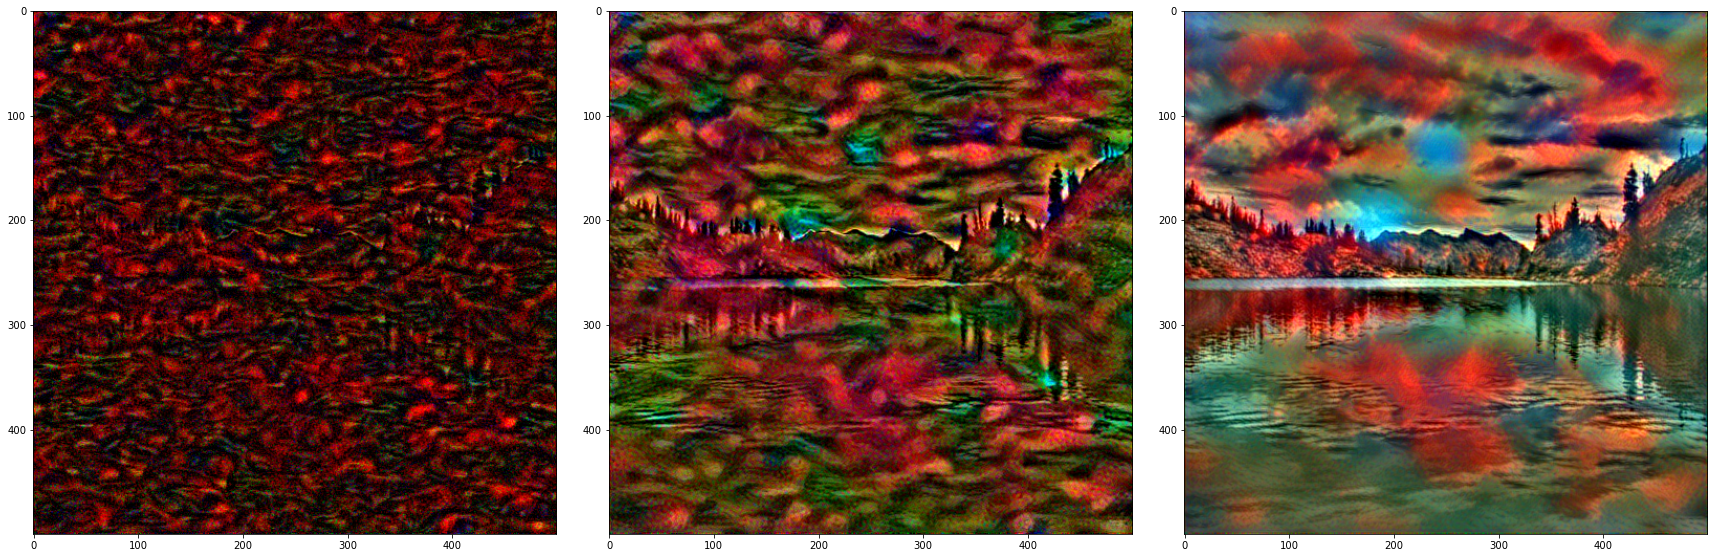

In [10]:
new = []
new.append(output_array[0])
new.append(output_array[1])
new.append(output_array[2])
plot_image_array(new)

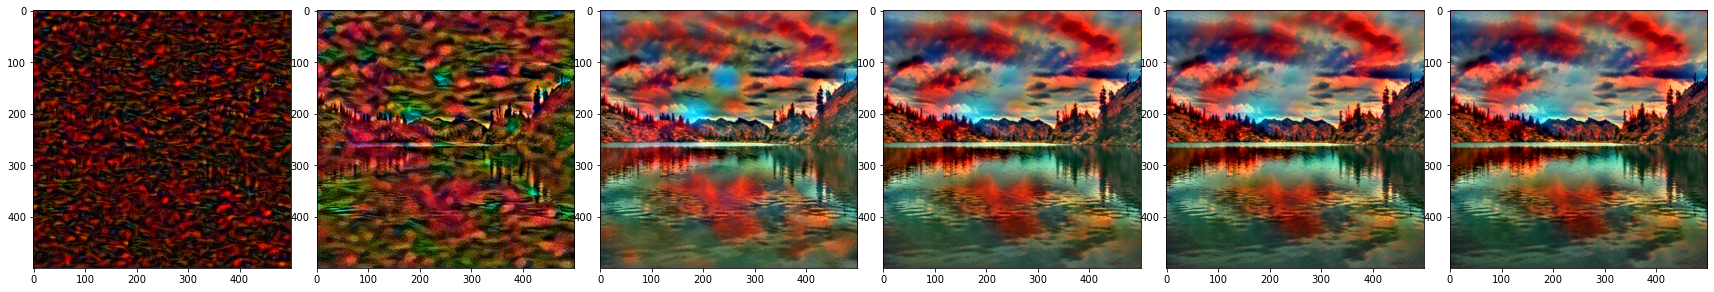

In [11]:
plot_image_array(output_array)

### The Output  follows an Inverse Exponential  Curve